# Freesound Audio Tagging 2019
## Automatically recognize sounds and apply tags of varying natures

Hello everyone, this kernel was developed to show a new approach of signal processing in machine learning.
The key here is the Wavelet Transform (WT), more information in [link 1](https://en.wikipedia.org/wiki/Wavelet_packet_decomposition) and [link 2](https://file.scirp.org/pdf/IJCNS20100300011_40520775.pdf). This is a useful tool for the analysis and classification of time-series and signal. There are diferentes implementations of WT: Continuous Wavelet Transform, Discrete Wavelet Transform and Wavelet Packet Decomposition.

In this kernel, we will use Wavelet Packet Decomposition and Random Forest Classifier.  
(Only train_curated dataset will be used)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt

#Audio
import IPython.display as ipd  # To play sound in the notebook
from scipy.io import wavfile
import gc

# Parallelization
from joblib import Parallel, delayed

#Classification
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics import roc_auc_score

# Signal processing
import scipy.stats

In [ ]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# PATH="../input/Santander/" 
PATH="../input/" 
print(os.listdir(PATH))
# Any results you write to the current directory are saved as output.

In [ ]:
%%time
train_curated = pd.read_csv(PATH+"train_curated.csv")
# train_noisy = pd.read_csv(PATH+"train_noisy.csv")
test = pd.read_csv(PATH+"sample_submission.csv")

# Preparing data

In [ ]:
print('Train curated size:' + format(train_curated.shape))
# print('Train noisy size:' + format(train_noisy.shape))
print('Test size: ' + format(test.shape))

In [ ]:
train_curated.head()

In [ ]:
test.head()

In [ ]:
#Creating a dictionary of labels
label_columns = list( test.columns[1:] )
label_mapping = dict((label, index) for index, label in enumerate(label_columns))
label_mapping

In [ ]:
def split_and_label(rows_labels):
    
    row_labels_list = []
    for row in rows_labels:
        row_labels = row.split(',')
        labels_array = np.zeros((80))
        
        for label in row_labels:
            index = label_mapping[label]
            labels_array[index] = 1
        
        row_labels_list.append(labels_array)
    
    return row_labels_list

In [ ]:
train_curated_labels = split_and_label(train_curated['labels'])
# train_noisy_labels   = split_and_label(train_noisy  ['labels'])
len(train_curated_labels) #, len(train_noisy_labels)

In [ ]:
for f in label_columns:
    train_curated[f] = 0.0
#     train_noisy[f] = 0.0

train_curated[label_columns] = train_curated_labels
# train_noisy[label_columns]   = train_noisy_labels

train_curated['num_labels'] = train_curated[label_columns].sum(axis=1)
# train_noisy['num_labels']   = train_noisy[label_columns].sum(axis=1)

train_curated['path'] = PATH+'train_curated/'+train_curated['fname']
# train_noisy  ['path'] = PATH+'train_noisy/'+train_noisy['fname']

train_curated.head()

In [ ]:
# train_noisy.head()

In [ ]:
train = train_curated
# train = pd.concat([train_curated, train_noisy],axis=0) # Using both datasets

del train_curated  #, train_noisy
gc.collect()

train.shape

In [ ]:
train.describe()

# Wavelet packet descomposition (WPD)

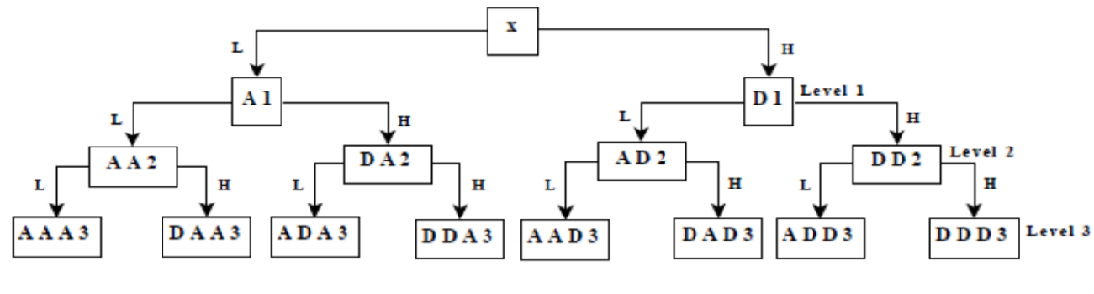
We will use WPD to Level 6. Where, a total of 64 new signal are obtained. For each new signal, a statistics feature group are obtanied. 

In [ ]:
import pywt
import scipy as sc

### Zero pading
Useful information
[Link 1](http://www.bitweenie.com/listings/fft-zero-padding/)
[Link 2](https://www.youtube.com/watch?v=ukHTfD37THI)

In [ ]:
def zero_padding(data, seconds):
    fs = 44100  # 2 seconds =  88200 samples    
    if data.shape[0] < seconds*fs:
        zeros = np.zeros(seconds*fs - data.shape[0])
        data = np.concatenate((data, zeros), axis=None)    
    return data

### Feature extraction methods

In [ ]:
from collections import defaultdict, Counter
from scipy.stats import kurtosis
from scipy.stats import skew

def _kurtosis(x):
    return kurtosis(x)

def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    xn_i1 = x[0:len(x)-2]  # xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:]) 

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 2
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)



In [ ]:
from scipy.stats import kurtosis
from scipy.stats import skew #skewness

def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy
 
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    # New features
    kur = kurtosis(list_values)
    MeanAbs = mean_abs(list_values)
    norm_ent = norm_entropy(list_values)
    skewness = skew(list_values)
    CPT_5 = CPT5(list_values)
    SSC_1 = SSC(list_values)
    WL = wave_length(list_values)
    SRAV_1 = SRAV(list_values)
    return [n5, n25, n75, n95, median, mean, std, var, rms, kur, MeanAbs, norm_ent, skewness, CPT_5, SSC_1, WL, SRAV_1]
 
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]
 

In [ ]:
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics    

In [ ]:
from sklearn.preprocessing import StandardScaler


def feature_extraction_wpd(path_names, level, seconds):
    # Sampling rate
    fs = 44100    
    corpus = []
    
    for fname in tqdm_notebook(path_names):        

        fs, data = wavfile.read(fname)    
        data = data.astype(float)
        
        # Zero padding
        if data.shape[0] < (seconds*fs):
            data = zero_padding(data,seconds)
        elif data.shape[0] > (seconds*fs):
            data = data[0:seconds*fs]
        elif data.shape[0] == 0:
            raise Exception('Lenght of x should not be 0. The value of lenght of x was: {}'.format(data.shape[0]))
            
        # Signal standarization
        data_std = StandardScaler().fit_transform(data.reshape(-1,1)).reshape(1,-1)[0]            
        
        # WPD tree
        wptree = pywt.WaveletPacket(data=data_std, wavelet='db5', mode='symmetric', maxlevel=level)
        levels = wptree.get_level(level, order = "freq")            
        
        #Feature extraction for each node
        features = []        
        for node in levels:
            data_wp = node.data
            # Features group
            features.extend(get_features(data_wp))
        corpus.append(features)
    # Delate first row
    return np.array(corpus)
     

In [ ]:
%%time
path_names = train.path.values
level = 6
seconds = 2
X_train = feature_extraction_wpd(path_names,level,seconds)

In [ ]:
path_names.shape, X_train.shape

Train set ready!

In [ ]:
test.shape

In [ ]:
%%time
path_test = PATH+'test/'
path_names = path_test + test['fname'].values
X_test = feature_extraction_wpd(path_names,level, seconds) 

Test set ready!

Cleaning Nan and Inf values

In [53]:
X_train[~np.isfinite(X_train)] = 0
X_test[~np.isfinite(X_test)] = 0

In [54]:
X_train = np.float32(X_train)
X_test = np.float32(X_test)

In [55]:
X_train[~np.isfinite(X_train)] = 0
X_test[~np.isfinite(X_test)] = 0

# Classification

Information about Random Forest classifier:
[Link](https://medium.com/machine-learning-101/chapter-5-random-forest-classifier-56dc7425c3e1)

In [ ]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=69)

PREDTRAIN = np.zeros( (X_train.shape[0],80))
PREDTEST  = np.zeros( (X_test.shape[0],80))
for f in range(len(label_columns)):
    y = train[ label_columns[f]].values
    oof      = np.zeros( X_train.shape[0] )
    oof_test = np.zeros( X_test.shape[0] )
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,y)):
        
        # Random Forest classifier
        model = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)
        model.fit(X_train[trn_idx,:], y[trn_idx])
        
        oof[val_idx] = model.predict_proba(X_train[val_idx,:])[:,1] 
        oof_test += model.predict_proba(X_test)[:,1]/5.0

    PREDTRAIN[:,f] = oof    
    PREDTEST [:,f] = oof_test
    
    print( f, str(roc_auc_score( y, oof ))[:6], label_columns[f] )

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

0 0.8859 Accelerating_and_revving_and_vroom


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

1 0.9837 Accordion


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

2 0.9698 Acoustic_guitar


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

3 0.9308 Applause


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

4 0.8868 Bark


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

5 0.9444 Bass_drum


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

6 0.9830 Bass_guitar


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

7 0.8491 Bathtub_(filling_or_washing)


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

8 0.9736 Bicycle_bell


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

9 0.8645 Burping_and_eructation


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

10 0.9187 Bus


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

11 0.8385 Buzz


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out,

12 0.9331 Car_passing_by


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [ ]:
def calculate_overall_lwlrap_sklearn(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

print( 'CV:', calculate_overall_lwlrap_sklearn( train[label_columns].values, PREDTRAIN ) )

In [ ]:
PREDTEST.shape, test.shape, X_test.shape

In [ ]:
test[label_columns] = PREDTEST 
test.to_csv('submission.csv', index=False)
test.head()